In [ ]:
import tensorflow as tf
print(tf.__version__)

2.4.0


In [ ]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
!ls

drive  sample_data  X.pickle  y.pickle


In [ ]:
# with tf.device('/gpu:0'):

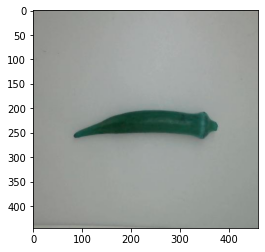

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
from tqdm import tqdm
from skimage.color import rgb2gray
%matplotlib inline
from scipy import ndimage

DATADIR = "/content/drive/My Drive/okra_image/aJuly_samples"

CATEGORIES = ["cla", "clb"] #

for category in CATEGORIES:  
    path = os.path.join(DATADIR,category)  # create path 
    for img in os.listdir(path):  # iterate over each image 
        img_array = cv2.imread(os.path.join(path,img) )  # convert to array
        plt.imshow(img_array, cmap='gray')  # graph it
        plt.show()  # display!

        break  
    break  

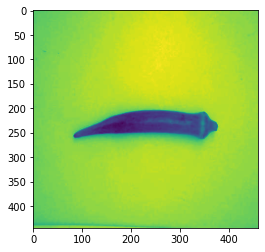

In [ ]:
imagex = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)
gray = rgb2gray(imagex)
plt.imshow(gray)

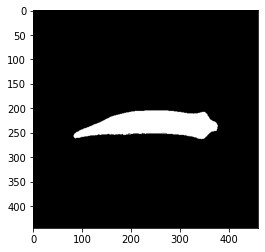

In [ ]:
gray_r = gray.reshape(gray.shape[0]*gray.shape[1])
for i in range(gray_r.shape[0]):
    if gray_r[i] > np.amax(gray_r)*0.47:
    #if gray_r[i] > gray_r.mean():
        gray_r[i] = 0
    else:
        gray_r[i] = 1
gray = gray_r.reshape(gray.shape[0],gray.shape[1])
plt.imshow(gray, cmap='gray')

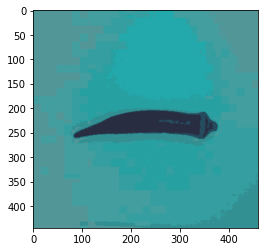

In [ ]:
image = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)
#image = img_array
HLS_img = cv2.cvtColor(img_array, cv2.COLOR_BGR2HLS)
r,g,b = cv2.split(image)
h,l,s = cv2.split(HLS_img)
image = cv2.merge((h,l,g,))

image = image.reshape((-1,3))


image = np.float32(image)

# define criteria, number of clusters(K) and apply kmeans()
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)
K = 8
ret,label,center=cv2.kmeans(image,K,None,criteria,10,cv2.KMEANS_RANDOM_CENTERS)


center = np.uint8(center)
res = center[label.flatten()]

res2 = res.reshape((img_array.shape))



plt.imshow(res2)

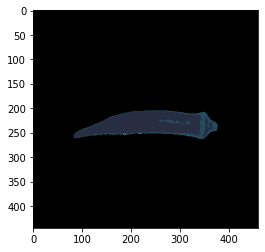

In [ ]:
new_img = np.zeros(res2.shape, dtype='uint8')
for i in [0,1,2]:
    new_img[:,:,i] = res2[:,:,i]*gray
    plt.imshow(new_img)

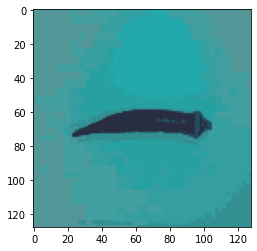

In [ ]:
#IMG_SIZE = 50
IMG_LONG = 128
IMG_LARGE = 128

new_array = cv2.resize(res2, (IMG_LONG, IMG_LARGE))
plt.imshow(new_array, cmap='gray')
#plt.show()

In [ ]:
training_data = []
#with tf.device('/gpu:0'):
      
def create_training_data():
    for category in CATEGORIES:  # do 

        path = os.path.join(DATADIR,category)  # create path
        class_num = CATEGORIES.index(category)  # get the classification  (0 or a 1). 

        for img in tqdm(os.listdir(path)):  # iterate over each image 
            try:
                img_array = cv2.imread(os.path.join(path,img))  # convert to array ->  ,cv2.IMREAD_GRAYSCALE for grayscaling
            
            #__________________________________________________________________________________________
                image = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)
                #image = img_array
                HLS_img = cv2.cvtColor(img_array, cv2.COLOR_BGR2HLS)
                r,g,b = cv2.split(image)
                h,l,s = cv2.split(HLS_img)
                image = cv2.merge((h,l,g,))
                image = image.reshape((-1,3))
                image = np.float32(image)

                # define criteria, number of clusters(K) and apply kmeans()
                criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)
                K = 10
                ret,label,center=cv2.kmeans(image,K,None,criteria,10,cv2.KMEANS_RANDOM_CENTERS)


                center = np.uint8(center)
                res = center[label.flatten()]
                res2 = res.reshape((img_array.shape))
                
            #_____________________________________________________________________________________________
            
                new_img = cv2.resize(res2, (IMG_LARGE, IMG_LONG))
                #new_img = cv2.rotate(new_img, cv2.ROTATE_90_COUNTERCLOCKWISE)
                
            #_____________________________________________________________________________________________
                
                training_data.append([new_img, class_num])  
            except Exception as e: 
                pass

create_training_data()

print(len(training_data))

100%|██████████| 114/114 [11:40<00:00,  6.14s/it]

227


In [ ]:
import random

random.shuffle(training_data)
for sample in training_data[:10]:
    print(sample[1])

1
0
0
1
0
0
0
1
1
0


In [ ]:
X = []
y = []

for features,label in training_data:
    X.append(features)
    y.append(label)

#print(X[0].reshape(-1, IMG_LONG, IMG_LARGE, 3))

X = np.array(X).reshape(-1, IMG_LONG, IMG_LARGE, 3)
print(X.shape)

(227, 128, 128, 3)


In [ ]:
y = np.array(y)
print(len(y))

227


In [ ]:
import pickle

pickle_out = open("X.pickle","wb")
pickle.dump(X, pickle_out)
pickle_out.close()

pickle_out = open("y.pickle","wb")
pickle.dump(y, pickle_out)
pickle_out.close()

In [ ]:
pickle_in = open("X.pickle","rb")
X = pickle.load(pickle_in)

pickle_in = open("y.pickle","rb")
y = pickle.load(pickle_in)



In [ ]:
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D

import pickle

pickle_in = open("X.pickle","rb")
X = pickle.load(pickle_in)

pickle_in = open("y.pickle","rb")
y = pickle.load(pickle_in)

X = X/255.0
with tf.device('/gpu:0'):
    model = Sequential()

    model.add(Conv2D(256, (3, 3), input_shape=X.shape[1:]))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(64, (3, 3)))

    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(32, (3, 3)))
    model.add(Conv2D(32, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    
    model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors

    model.add(Dense(64))
    model.add(Activation('relu'))

    model.add(Dense(1))
    model.add(Activation('sigmoid'))

    model.compile(loss='binary_crossentropy',
                optimizer='nadam',
                metrics=['accuracy']
                )
    epochs = 70
    history = model.fit(X, y, batch_size=32, epochs=epochs, validation_split=0.2)

Epoch 1/70
6/6 [==============================] - 1s 84ms/step - loss: 0.6964 - accuracy: 0.5028 - val_loss: 0.7098 - val_accuracy: 0.4130
Epoch 2/70
6/6 [==============================] - 0s 55ms/step - loss: 0.6883 - accuracy: 0.5083 - val_loss: 0.6798 - val_accuracy: 0.8913
Epoch 3/70
6/6 [==============================] - 0s 55ms/step - loss: 0.8320 - accuracy: 0.7680 - val_loss: 0.5084 - val_accuracy: 0.9130
Epoch 4/70
6/6 [==============================] - 0s 55ms/step - loss: 0.4630 - accuracy: 0.7790 - val_loss: 0.4086 - val_accuracy: 0.8261
Epoch 5/70
6/6 [==============================] - 0s 56ms/step - loss: 0.8833 - accuracy: 0.7956 - val_loss: 0.3002 - val_accuracy: 0.9130
Epoch 6/70
6/6 [==============================] - 0s 55ms/step - loss: 0.1670 - accuracy: 0.9448 - val_loss: 0.2285 - val_accuracy: 0.9348
Epoch 7/70
6/6 [==============================] - 0s 56ms/step - loss: 0.0861 - accuracy: 0.9834 - val_loss: 0.2508 - val_accuracy: 0.9348
Epoch 8/70
6/6 [===========

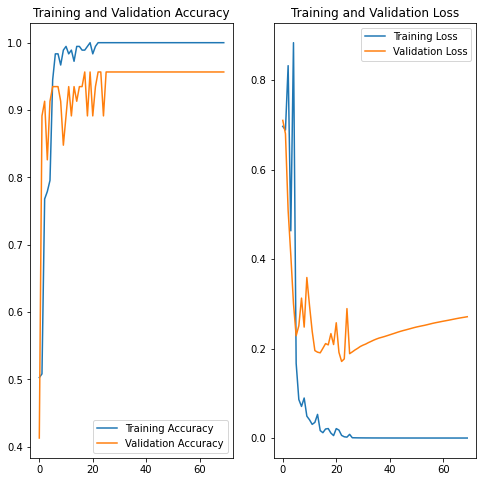

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow import keras
from tensorflow.keras import layers

with tf.device('/gpu:0'):
    model = Sequential()

    #model.add(tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal", input_shape=X.shape[1:]))
    layers.experimental.preprocessing.RandomFlip("vertical", 
                                                    input_shape=(IMG_LONG, 
                                                                IMG_LARGE,
                                                                3))
    model.add(tf.keras.layers.experimental.preprocessing.RandomRotation(0.2))
    model.add(tf.keras.layers.experimental.preprocessing.RandomZoom(0.1))
    model.add(Conv2D(256, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(64, (3, 3)))

    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(32, (3, 3)))
    model.add(Conv2D(32, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    model.add(Flatten()) 

    model.add(Dense(64))
    model.add(Activation('relu'))

    model.add(Dense(1))
    model.add(Activation('sigmoid'))

    model.compile(loss='binary_crossentropy',
                    optimizer='nadam',
                    metrics=['accuracy']
                    )
    epochs = 50
    history_2 = model.fit(X, y, batch_size=32, epochs=epochs, validation_split=0.2)
    model.save('/content/drive/My Drive/okra_image/CNN_data_aug.model')

Epoch 1/50
6/6 [==============================] - 1s 87ms/step - loss: 0.7027 - accuracy: 0.4862 - val_loss: 0.6971 - val_accuracy: 0.4130
Epoch 2/50
6/6 [==============================] - 0s 61ms/step - loss: 0.6935 - accuracy: 0.4586 - val_loss: 0.6896 - val_accuracy: 0.8043
Epoch 3/50
6/6 [==============================] - 0s 59ms/step - loss: 0.6968 - accuracy: 0.5083 - val_loss: 0.6836 - val_accuracy: 0.7826
Epoch 4/50
6/6 [==============================] - 0s 59ms/step - loss: 0.6719 - accuracy: 0.6077 - val_loss: 0.5712 - val_accuracy: 0.8913
Epoch 5/50
6/6 [==============================] - 0s 59ms/step - loss: 0.7170 - accuracy: 0.5470 - val_loss: 0.6675 - val_accuracy: 0.6957
Epoch 6/50
6/6 [==============================] - 0s 58ms/step - loss: 0.6999 - accuracy: 0.5249 - val_loss: 0.6956 - val_accuracy: 0.4130
Epoch 7/50
6/6 [==============================] - 0s 59ms/step - loss: 0.6905 - accuracy: 0.5193 - val_loss: 0.6864 - val_accuracy: 0.4130
Epoch 8/50
6/6 [===========

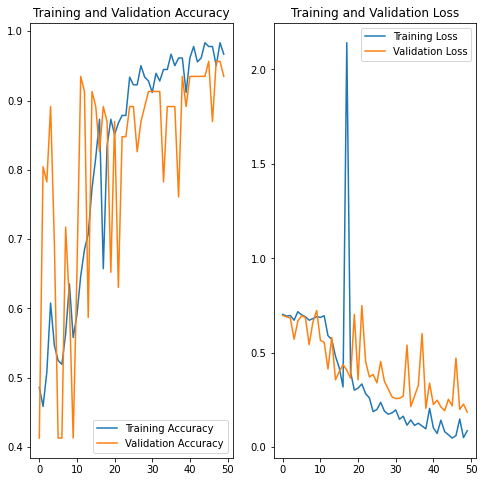

In [ ]:
acc = history_2.history['accuracy']
val_acc = history_2.history['val_accuracy']

loss=history_2.history['loss']
val_loss=history_2.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
from tensorflow import keras
model = keras.models.load_model('/content/drive/My Drive/okra_image/CNN_data_aug.model')

In [ ]:
testing_data = []
DATADIR = "/content/drive/My Drive/okra_image/August_samples"
CATEGORIES = ["cla", "clb"] #

#with tf.device('/gpu:0'):
      
def create_testing_data():
    for category in CATEGORIES:  # do 

        path = os.path.join(DATADIR,category)  # create path
        class_num = CATEGORIES.index(category)  # get the classification  (0 or a 1). 

        for img in tqdm(os.listdir(path)):  # iterate over each image 
            try:
                img_array = cv2.imread(os.path.join(path,img))  # convert to array ->  ,cv2.IMREAD_GRAYSCALE for grayscaling
            
            #__________________________________________________________________________________________
                image = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)
                #image = img_array
                HLS_img = cv2.cvtColor(img_array, cv2.COLOR_BGR2HLS)
                r,g,b = cv2.split(image)
                h,l,s = cv2.split(HLS_img)
                image = cv2.merge((h,l,g,))
                image = image.reshape((-1,3))
                image = np.float32(image)

                # define criteria, number of clusters(K) and apply kmeans()
                criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)
                K = 8
                ret,label,center=cv2.kmeans(image,K,None,criteria,10,cv2.KMEANS_RANDOM_CENTERS)


                center = np.uint8(center)
                res = center[label.flatten()]
                res2 = res.reshape((img_array.shape))
                
            #_____________________________________________________________________________________________
            
                new_img = cv2.resize(res2, (IMG_LARGE, IMG_LONG))
                new_img = cv2.rotate(new_img, cv2.ROTATE_90_COUNTERCLOCKWISE)
                #accuracy on y, x for the training number
            #_____________________________________________________________________________________________
                
                testing_data.append([new_img, class_num])  # add this to our training_data
            except Exception as e:  # in the interest in keeping the output clean...
                pass
            #except OSError as e:
            #    print("OSErrroBad img most likely", e, os.path.join(path,img))
            #except Exception as e:
            #    print("general exception", e, os.path.join(path,img))

create_testing_data()




100%|██████████| 15/15 [01:17<00:00,  5.14s/it]


In [ ]:
print(len(testing_data))

30


In [ ]:
import random

random.shuffle(testing_data)
for sample in testing_data[:10]:
    print(sample[1])

0
1
0
1
1
0
1
0
0
0


In [ ]:
A = []
b = []

for features,label in testing_data:
    A.append(features)
    b.append(label)

#print(A[0].reshape(-1, IMG_LARGE, IMG_LONG, 3))

A = np.array(A)#.reshape(-1, IMG_LARGE, IMG_LONG, 3)
b = np.array(b)

A = A/255.0
print(A.shape)
#print((A[0]))

(30, 128, 128, 3)


In [ ]:
#model = tf.keras.models.load_model("64x3-CNN.model")

predicted_classes = model.predict(A)
#print(len(predicted_classes))
#print(predicted_classes)

In [ ]:
predicted_classes = np.around(predicted_classes, decimals= 0)
#print(predicted_classes)
predicted_classes = predicted_classes.astype(int)

prdcls = []
for a in predicted_classes:
    for c in a:
        prdcls.append(c)

In [ ]:
predicted_classes.shape, b.shape

((30, 1), (30,))

In [ ]:
import sys
import numpy
numpy.set_printoptions(threshold=sys.maxsize)

prdcls = np.array(prdcls)
predicted_classes = prdcls
print(predicted_classes)
print(b)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 1 0 1 1 0 1 0 0 0 1 1 1 1 1 0 1 0 0 0 0 0 1 0 1 0 1 1 1 0]


30
Found 15 incorrect labels
Accuracy:  50.0 %
Incorrect = 50.0 %


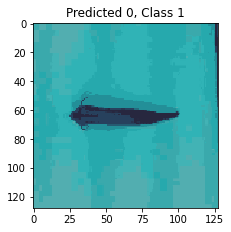

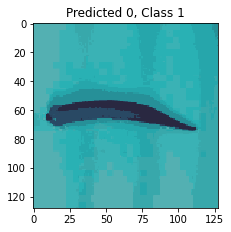

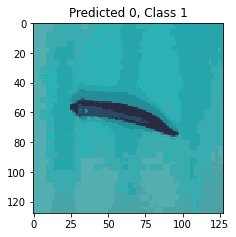

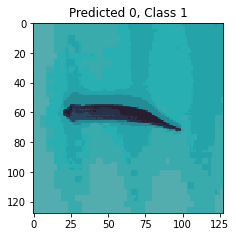

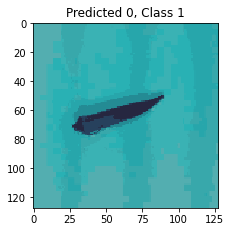

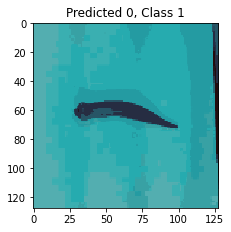

In [ ]:
#X = np.array(X).reshape(-1, IMG_LARGE, IMG_LONG, 3)
incorrect = np.where(predicted_classes!= b)[0]
correct = np.where(predicted_classes == b) [0]
print(len(predicted_classes))
print("Found %d incorrect labels" % len(incorrect))
print("Accuracy: " , float((len(correct)*100)/len(predicted_classes)),"%")
print("Incorrect =", float((len(incorrect)*100)/len(predicted_classes)),"%")
for i, incorrect in enumerate(incorrect[:6]):
    plt.figure(figsize=(10,9))
    plt.subplot(3,2,i+1)
    plt.imshow(A[incorrect], cmap='gray', interpolation='nearest')
    #plt.imshow()
    #print(A[incorrect])
    plt.title("Predicted {}, Class {}".format(predicted_classes[incorrect], b[incorrect]))
    plt.tight_layout()

In [ ]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 6521738060559488726, name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 16234388043511694121
 physical_device_desc: "device: XLA_CPU device", name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 14948511270487060404
 physical_device_desc: "device: XLA_GPU device", name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 14613293312
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 2218066973035928037
 physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"]

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
print("Tensorflow version " + tf.__version__)

try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
  raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

Tensorflow version 2.3.0
Running on TPU  ['10.126.23.34:8470']
INFO:tensorflow:Initializing the TPU system: grpc://10.126.23.34:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.126.23.34:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


In [ ]:
l = [1,2,3,4,5,6,7,8,9,0,1,2,3,4,5,6,7,8,9,0]
slist = l[:9]
for i in l[9:][::3]:
    slist.extend(l[9+i-3: 9+i])
    print(slist)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 7, 8, 9]
[1, 2, 3, 4, 5, 6, 7, 8, 9, 7, 8, 9, 0, 1, 2]
[1, 2, 3, 4, 5, 6, 7, 8, 9, 7, 8, 9, 0, 1, 2, 3, 4, 5]
[1, 2, 3, 4, 5, 6, 7, 8, 9, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8]


In [ ]:
l = [1,2,3,4,5,6,7,8,9,0,1,2,3,4,5,6,7,8,9,0]
slist = l[:9]
for i in l[9:][::2]:
    slist.extend(l[9+i-1: 9+i+1])
    print(slist)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 9, 0]
[1, 2, 3, 4, 5, 6, 7, 8, 9, 9, 0, 1, 2]
[1, 2, 3, 4, 5, 6, 7, 8, 9, 9, 0, 1, 2, 3, 4]
[1, 2, 3, 4, 5, 6, 7, 8, 9, 9, 0, 1, 2, 3, 4, 5, 6]
[1, 2, 3, 4, 5, 6, 7, 8, 9, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8]
[1, 2, 3, 4, 5, 6, 7, 8, 9, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0]


In [ ]:
list=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]
slist= list[:9]
s,f=0,2
for i in range(3):
    slist+=(list[9:][s:f])
    print(slist)
    s+=2
    f+=2

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]


In [ ]:
l = [1,2,3,4,5,6,7,8,9,0,1,2,3,4,5,6,7,8,9,0]
slist = l[:9]
for i in l[9:][::2]:
    if i == l[9]:
        slist.extend(l[9+i: 9+i+1])
    else:
        slist.extend(l[9+i-1: 9+i+1])
    print(slist)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 0]
[1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2]
[1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4]
[1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6]
[1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8]
[1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 0]


In [ ]:
list=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,
      16,17,18,19,20,22,23,24,25,26,27,28,29,30]
slist= list[:9]
s,f=0,2
for i in range(3):
    slist.extend(list[9:][s:f])
    print(slist)
    s+=2
    f+=2

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
